### Lighting Science Final Project  <br>
Takehiro Izumi, Amrit Shaw, Takuma Tsuruta <br>


Import necesarry librarieas and try to connect the DMX controller and JETI spectroradiometers.

In [62]:
from DMXEnttecPro import Controller
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
from luxpy.toolboxes import spdbuild as spb


# port = get_port_by_serial_number('EN279626')
# dmx = Controller(port, dmx_size=256)
cieobs = '1964_10'
try:
    dmx = Controller('COM5')
    sp.init('jeti')
except:
    dmx = None
    print('no connection')

def dmx_render(r,g,b,w,a,uv=0):
    dmx.set_channel(1, int(r))
    dmx.set_channel(2, int(g))
    dmx.set_channel(3, int(b))
    dmx.set_channel(4, int(w))
    dmx.set_channel(5, int(a))
    dmx.set_channel(6, int(uv))
    dmx.submit()

no connection


Turn on the laser pointer in JETI and check the measurement point.

In [21]:
if dmx is not None:
    sp.jeti.set_laser(laser_on=True)
    dmx_render(0,0,0,0,0)
    time.sleep(0.5)
    sp.jeti.set_laser(laser_on=False)


In [63]:
def calibrate(filename=None):
    if filename is None:
        assert dmx is not None
        now = datetime.datetime.now()
        filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
        if not os.path.exists(os.path.dirname(filename)):
            os.mkdir(os.path.dirname(filename))
        
        channels = [1, 2, 3, 4, 5]

        output_values = np.arange(0, 255, 10)
        # output_values = np.concatenate([np.arange(0, 20, 2), np.arange(20, 255, 40)])

        if output_values[-1] < 255:  # make sure the last output is max.
            output_values = np.append(output_values, 255)

        measured_spd_all = []
        measured_luminance_all = []

        for channel in channels:
            measured_spd = []
            measured_luminance = []
            for c in channels:
                dmx.set_channel(c, 0)
                dmx.submit()

            for v in output_values:
                print(channel, v)
                if dmx is not None:
                    dmx.set_channel(channel, v)
                    dmx.submit()
                    time.sleep(0.2)
                # Avoid to measure with 0 output because jeti can't be used in a dark room.
                if v <= 0:
                    measured_luminance.append(0)
                    measured_spd.append(None)
                else:
                    spd = sp.jeti.get_spd()
                    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
                    measured_luminance.append(l[0][0])
                    measured_spd.append(spd)

            #  fill None data as zero spectrum
            if measured_spd[0] is None:
                measured_spd[0] = measured_spd[1].copy()
                measured_spd[0][-1] = measured_spd[0][-1]*0
                
            print(measured_luminance)

            measured_spd_all.append(measured_spd)
            measured_luminance_all.append(measured_luminance)
        np.savez(filename, luminance=measured_luminance_all,
                spd=measured_spd_all, output_values=output_values, channels=channels)
        return np.load(filename+'.npz')
    return np.load(filename)
           

      

Calibrate the light source (or load existing calibrate data). <br>
Calculate output-value / output-luminance characteristic using poly fit function. <br>
Show the graphs if specified (is_plot = True).

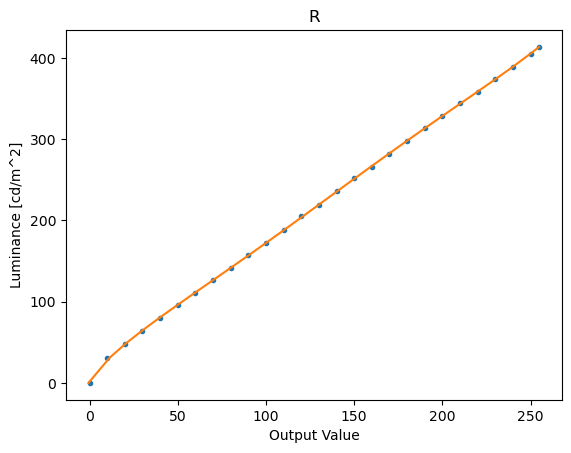

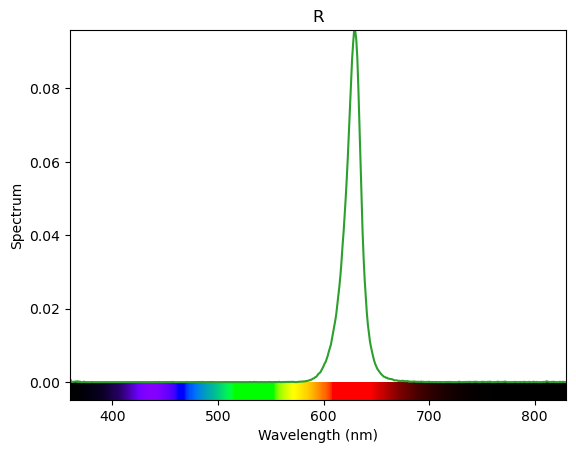

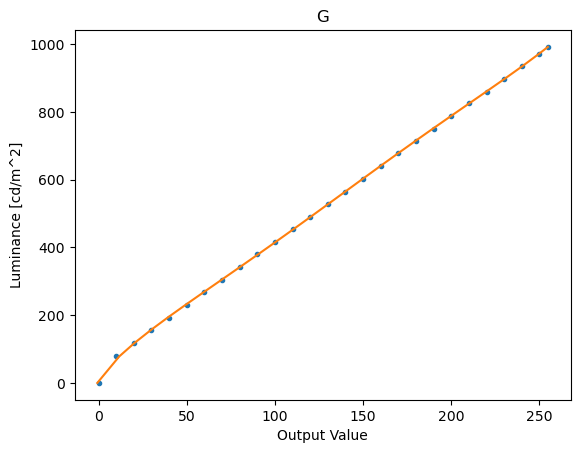

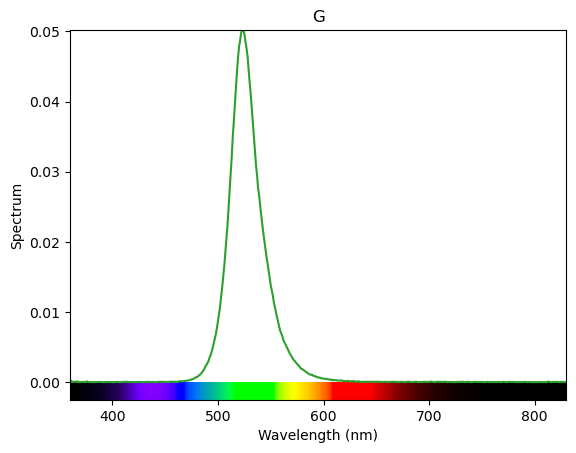

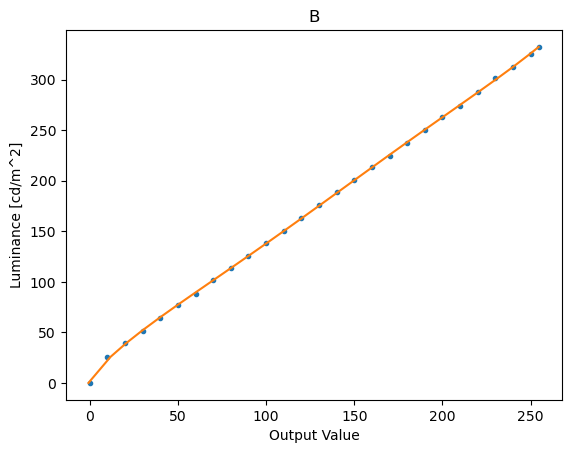

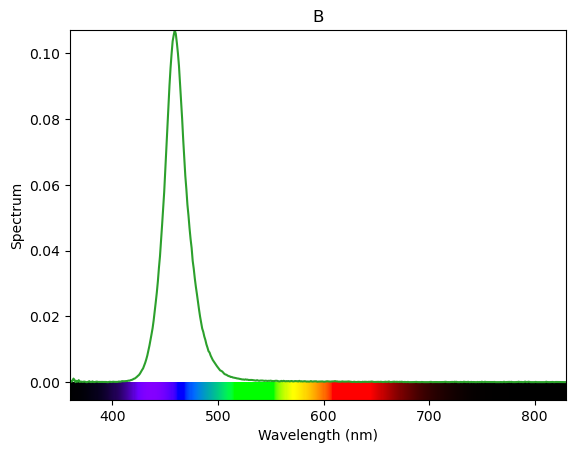

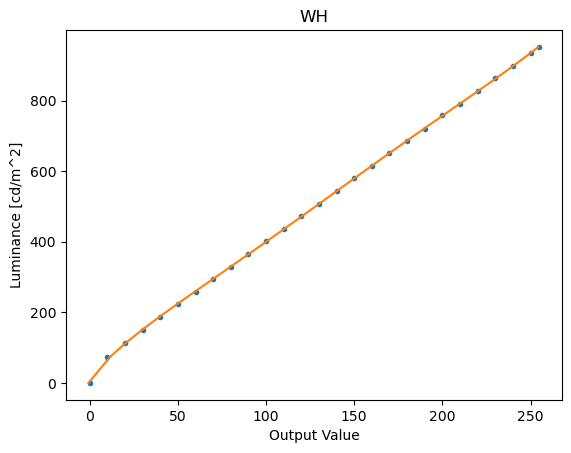

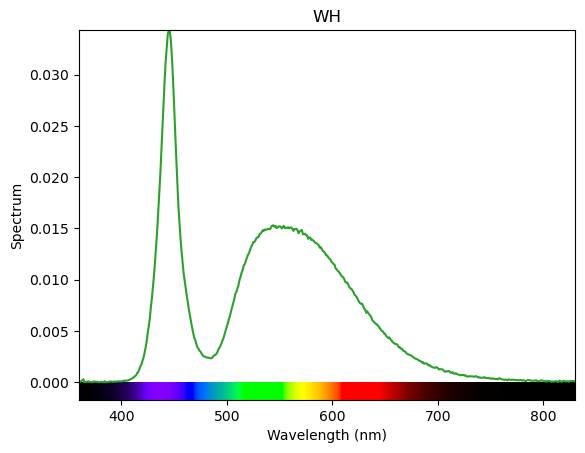

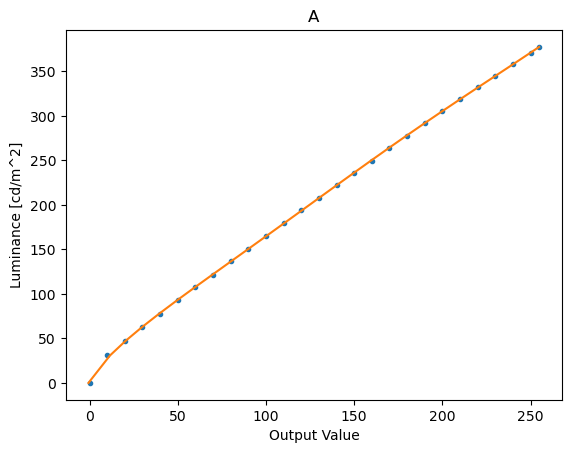

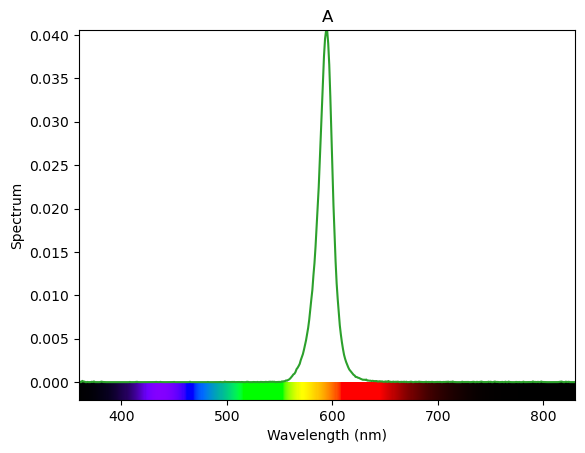

In [64]:
# f = 'output/data_20230324_163716.npz'
f = 'output/data_20230420_104200.npz'
is_plot = False
# is_plot = True
data = calibrate(f)

output_values = data['output_values']
channels = data['channels']
measured_luminance_all = data['luminance']
measured_spd_all = data['spd']
labels = ['R', 'G', 'B', 'WH', 'A', 'UV']

normL2output = []
output2L = []
    

for i, channel in enumerate(channels):
    luminance = np.asarray(measured_luminance_all[i])
    spd = measured_spd_all[i]
    luminance = luminance - measured_luminance_all[i][0]
    # normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))
    normalized_luminance = luminance / max(luminance)

    z = np.polyfit(luminance, output_values,5)
    z_norm = np.polyfit(normalized_luminance, output_values,5)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)
    normL2output.append(func_norm)
    
    z_output2L = np.polyfit(output_values, luminance, 5)
    f_ = np.poly1d(z_output2L)
    output2L.append(f_)

    if is_plot:
        plt.figure()
        plt.plot(output_values, luminance, '.')
        plt.plot(func(luminance), luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(output_values, normalized_luminance, '.')
        plt.plot(func_norm(normalized_luminance), normalized_luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))

        lx.SPD(spd[-1]).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


## 3-channels color mixing

92.10551848140486
Selected channels: ['R', 'G', 'B']
Optimized primary contributions: [7.1655e-02 6.0984e-02 2.9742e-02]
Output values of the light source: [11  8  3]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]


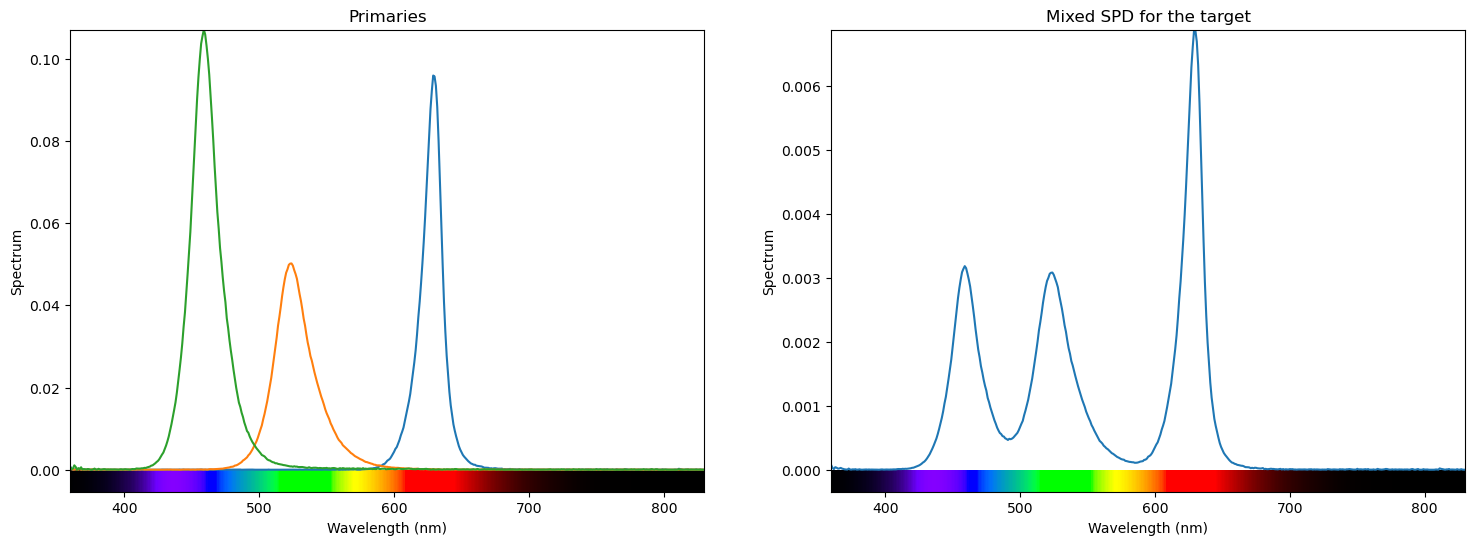

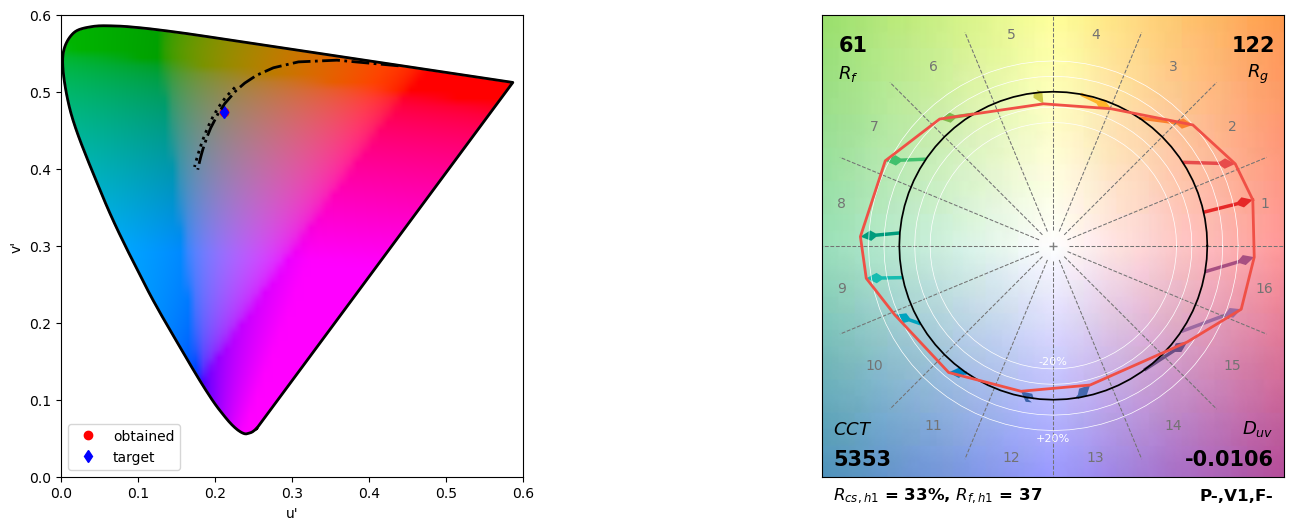


------------Measured------------


SerialException: WriteFile failed (PermissionError(13, 'Access is denied.', None, 5))

In [60]:
def getPrimarySPD(channels_idx):
    spd_p = []
    for c in channels_idx:
        spd = measured_spd_all[c][-1].copy()
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def getDriverValues(channels_idx, weights):
    output = []
    for i, w in zip(channels_idx, weights[0]):
        v = normL2output[i](w)
        output.append(v)
    output = np.around(output)
    return np.asarray(output, dtype = np.uint8)

def getL(channels_idx, output_values):
    L = []
    for i, w in zip(channels_idx, output_values):
        v = output2L[i](w)
        L.append(v)
    return L

    
def calculateOptimizedSPD(spd_p, weights):
    weighted_p = spd_p[0:2].copy()
    weighted_p[-1] *= 0
    for i, (p, w) in enumerate(zip(spd_p[1:], weights[0])):
        weighted_p[-1] += p*w
    return weighted_p

def showMixedSPD(spd_p, spd_optimized):
    fig,ax = plt.subplots(1,2, figsize=(18,6))
    plt.sca(ax[0]); 
    plt.title('Primaries')
    lx.SPD(spd_p).plot()
    plt.sca(ax[1]); 
    plt.title('Mixed SPD for the target')
    lx.SPD(spd_optimized).plot()

def evaluate(spd, xyz_t):
    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)

    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    print("Luminance [cd/m2] : {:1.1f}".format(l[0][0]))
    print("xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_obtained[0]))
    print("Target xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_t[0]))

    # default: CIE 1976 u’v’ chromaticity diagram
    Yuv_obtained = lx.xyz_to_Yuv(xyz_obtained)
    Yuv_target = lx.xyz_to_Yuv(xyz_t)
    Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
    Y, u, v = lx.utils.asplit(Yuv_obtained)
    # ax = plt.figure().add_subplot(121)
    
    fig, ax = plt.subplots(1,2,figsize=(18,6))

    ax[0].plot(u, v,
            color ='r', marker = 'o', linestyle = 'none', label='obtained')
    ax[0].plot(u_t, v_t,
            color ='b', marker ='d', linestyle = 'none', label='target')
    ax[0].set_xlabel("u'")  # set x-axis label
    ax[0].legend()
    ax[0].set_ylabel("v'")  # set y-axis label
    # # ax = plt.figure().add_subplot(122)
    lx.cri.plot_tm30_cvg(spd, axh=ax[1])

    lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=True,
          BBL=True, diagram_colors=True, axh=ax[0])


def measureSPD(channels_idx, output):
    if dmx is None:
       return
    for i, v in zip(channels_idx, output):
        # light source's channels start from 1
        dmx.set_channel(i+1, int(v))
    dmx.submit()
    time.sleep(1)
    spd = sp.jeti.get_spd()
    return spd

def color_mixing(xyz_t, channels_idx):
    Yxy_t = lx.xyz_to_Yxy(xyz_t)
    spd_p = getPrimarySPD(channels_idx=channels_idx)
    xyz_p = lx.spd_to_xyz(spd_p, relative=False, cieobs=cieobs) # always mention CIE when convert spd to colorimetric value
    Yxy_p = lx.xyz_to_Yxy(xyz_p)

    M_xyz = spb.colormixer_pinv(xyz_t, xyz_p, input_fmt='xyz') 
    M_Yxy = spb.colormixer_pinv(Yxy_t, Yxy_p, input_fmt='Yxy') 
    M = M_xyz
    output = getDriverValues(channels_idx, M)

    print(np.sum(getL(channels_idx, output)))
    print('Selected channels:', [labels[c] for c in channels_idx])
    print('Optimized primary contributions:', M[0])
    print('Output values of the light source:', output)

    print('\n-----------Optimized------------')
    spd_optimized = calculateOptimizedSPD(spd_p, M)
    showMixedSPD(spd_p, spd_optimized)
    evaluate(spd_optimized, xyz_t)

    if dmx is not None:
        print('\n------------Measured------------')
        spd_measured = measureSPD(channels_idx, output)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2]
color_mixing(xyz_t, channels_idx)




## 4-channels colormixing

Selected channels: ['R', 'G', 'B', 'A']
Optimized primary contributions: [2.4156e-01 2.7857e-01 1.4572e-01 1.8487e-01]
Output values of the light source: [52 62 30 36]

-----------Optimized------------
Luminance [cd/m2] : 500.0
xyz : [ 500.0, 500.0, 500.0 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


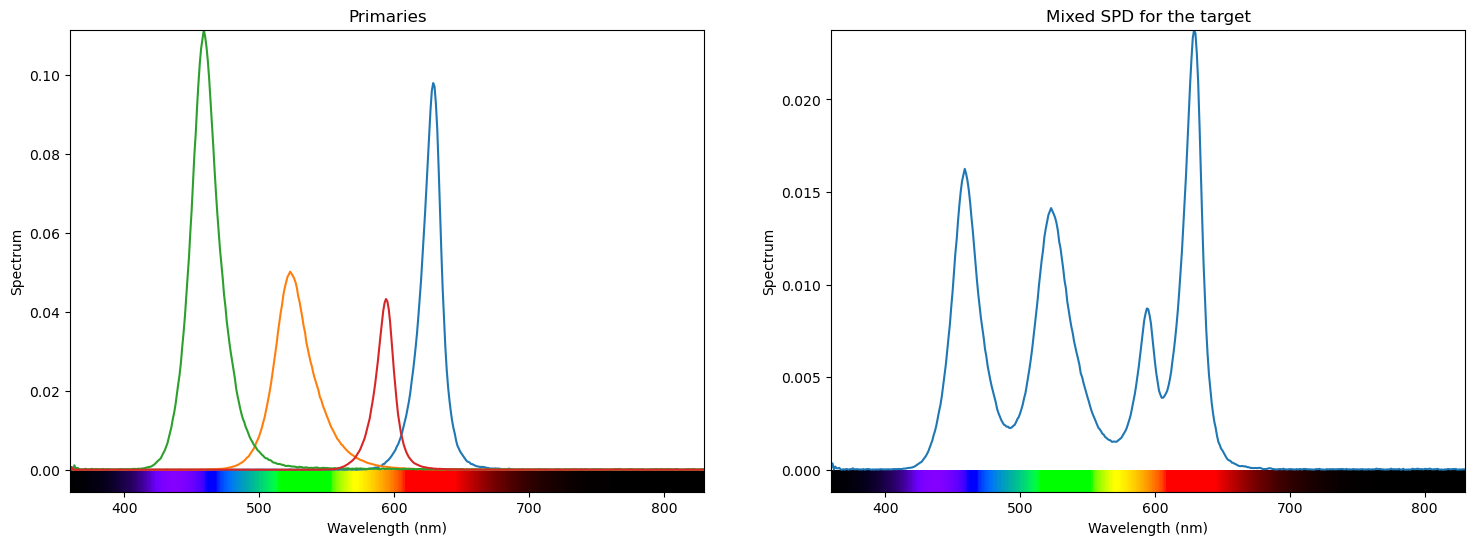

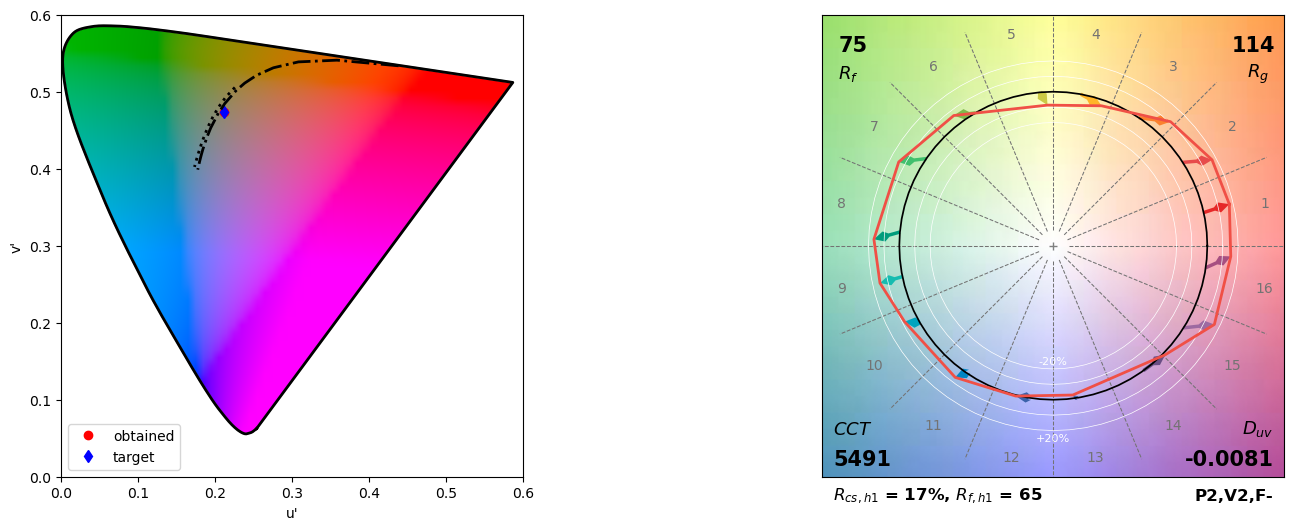


------------Measured------------
Luminance [cd/m2] : 173.2
xyz : [ 165.4, 173.2, 171.9 ]
Target xyz : [ 500.0, 500.0, 500.0 ]


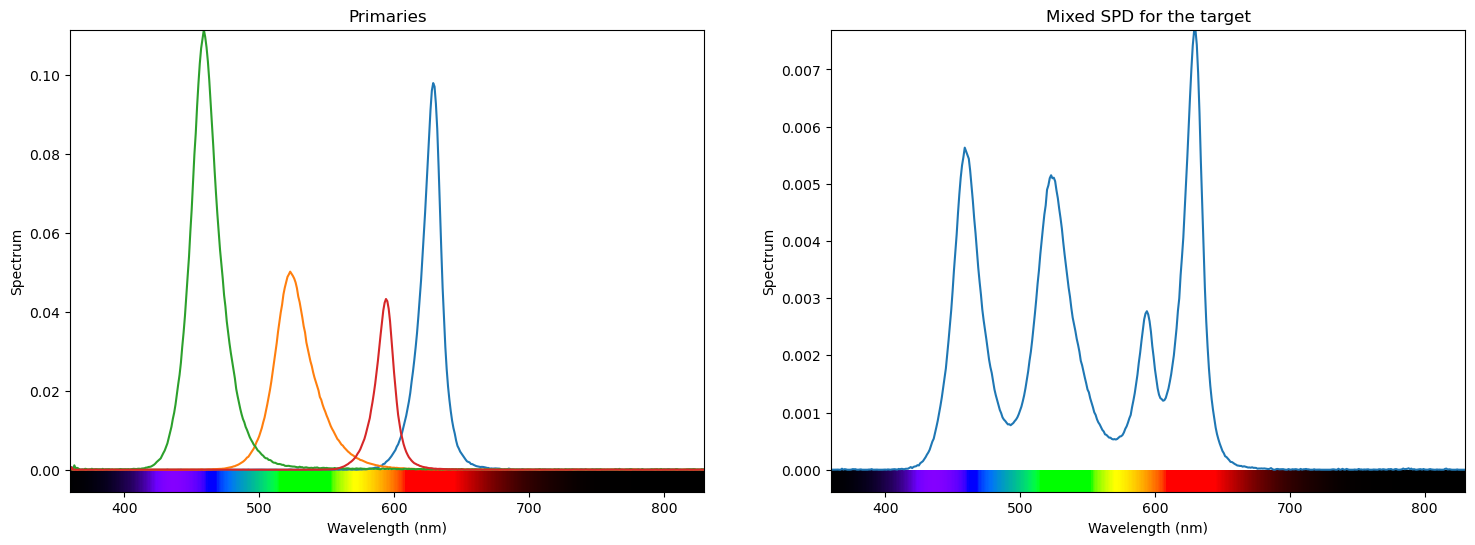

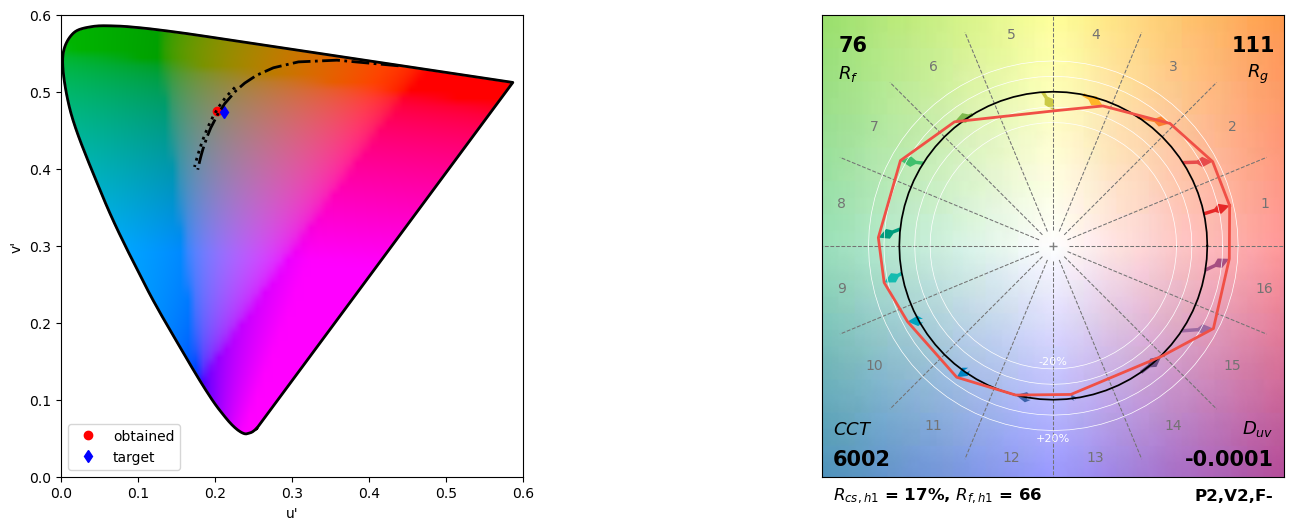

In [48]:
xyz_t = np.array([[100, 100, 100]])*5
channels_idx = [0, 1, 2, 4]
color_mixing(xyz_t,  channels_idx)

### Multi-objective optimizer

Running time for the optimization: 4.31 sec
Optimized primary contributions: [5.7751e-02 2.3389e-01 1.3257e-01 5.1804e-01 5.1965e-01]
Output values of the light source: [  8  51  26 126 121]

------Optimized Result-------
Results (optim,target):
Rf: (79.93, 80.00)
Rg: (95.33, 95.00)
CCT [K]: (5482.0, nan)
Duv: (-0.0041, nan)
LER [lm/W]: (357.3, nan)
Luminance [cd/m2] : 1000.0
xyz : [ 1000.0, 1000.0, 1000.0 ]
Target xyz : [ 1000.0, 1000.0, 1000.0 ]


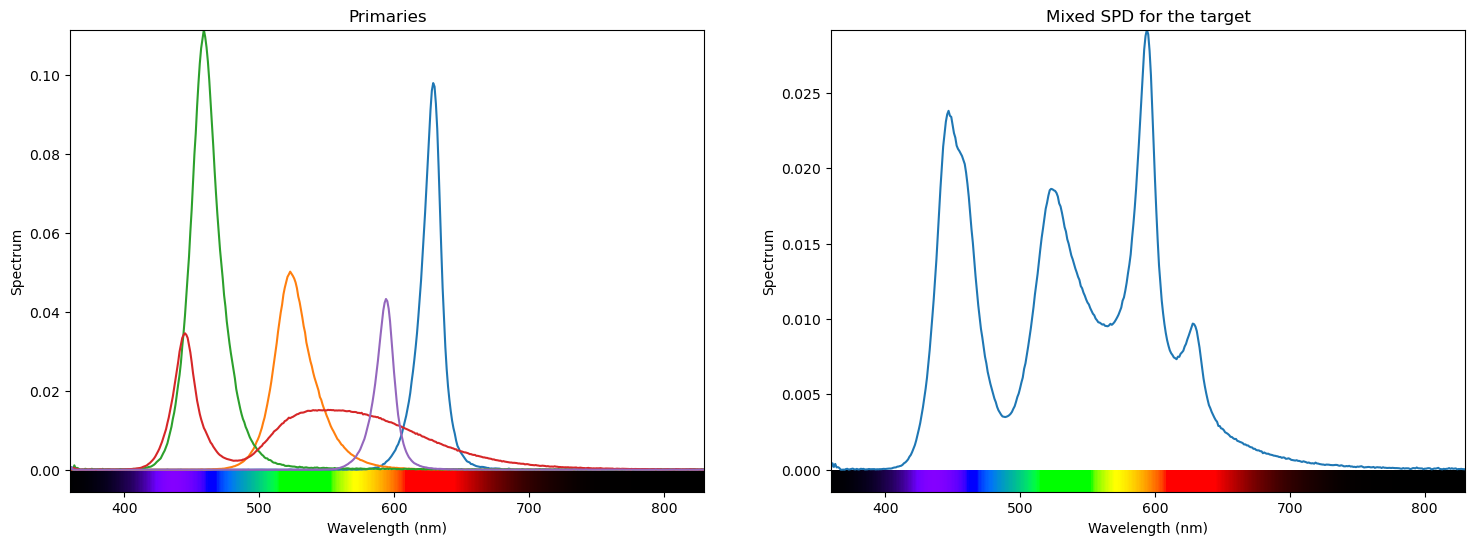

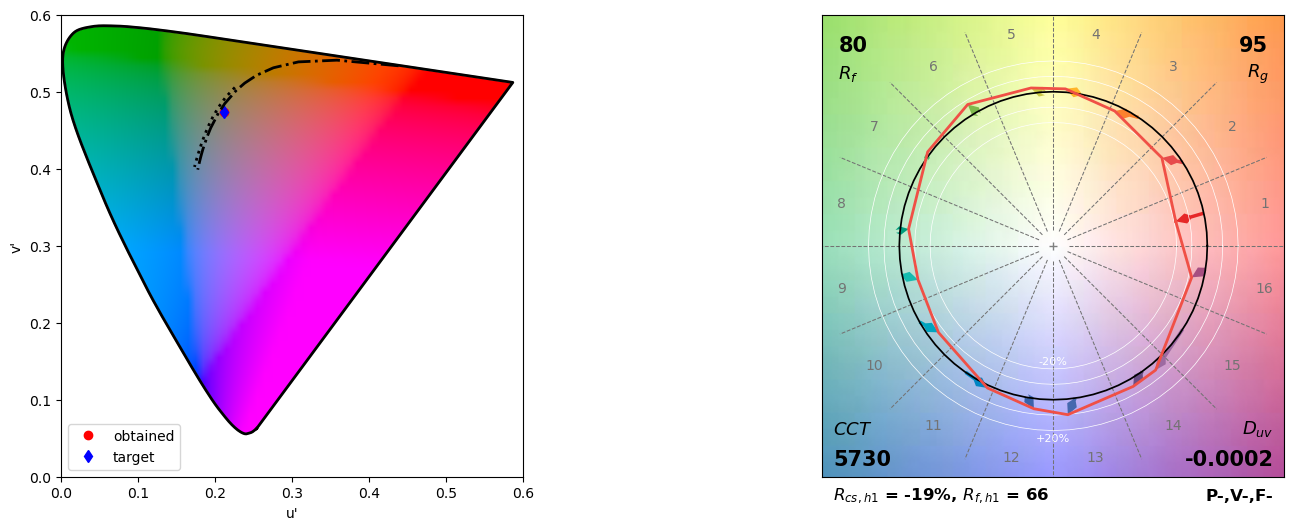

Measured
Luminance [cd/m2] : 434.7
xyz : [ 442.0, 434.7, 413.0 ]
Target xyz : [ 1000.0, 1000.0, 1000.0 ]


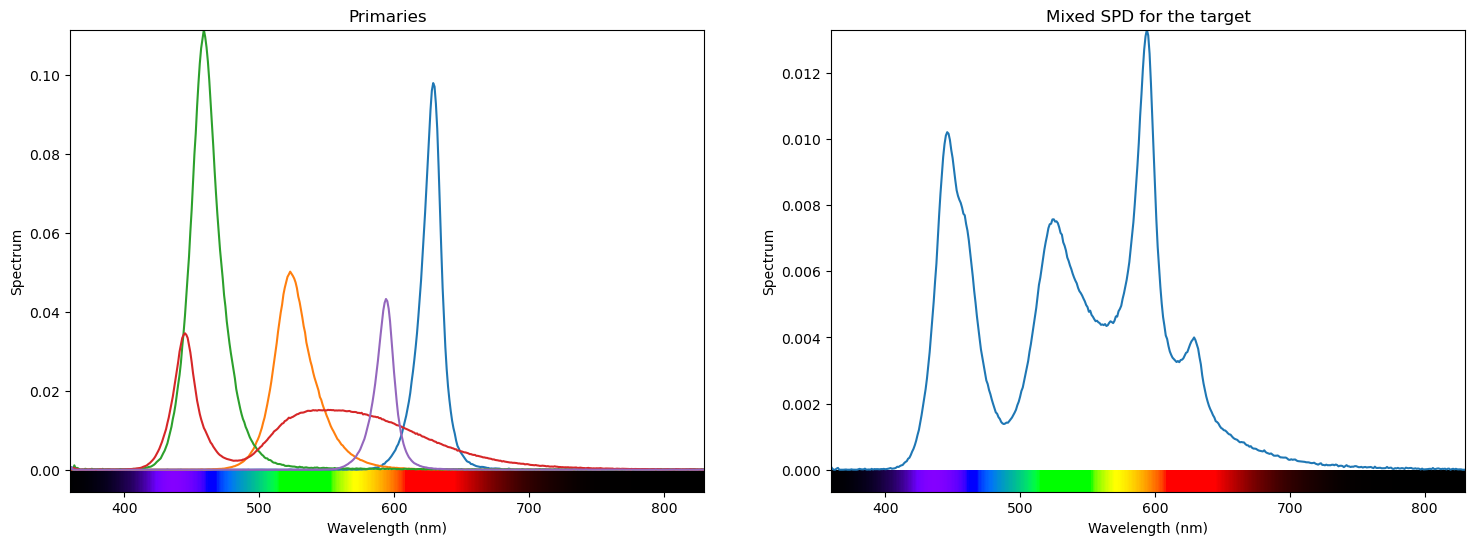

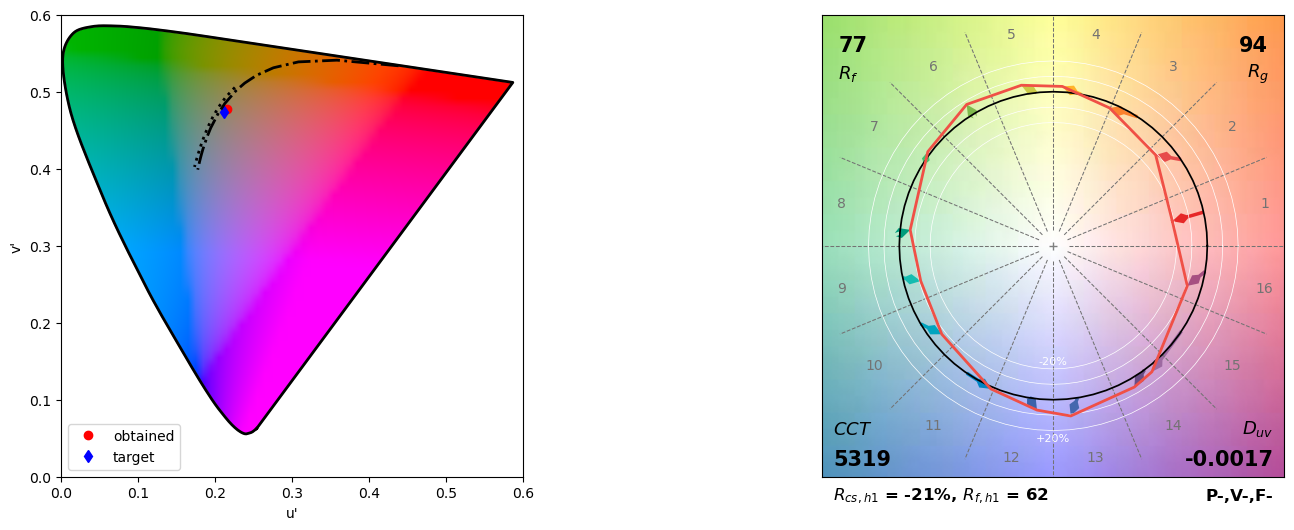

In [49]:
def spectralOptimization(channels_idx, xyz_t=None, Rf_Rg=None, CCT_Duv=None, LER=None, method='Nelder-Mead'):
    methods = ['Nelder-Mead', 'particleswarm', 'demo']
    if method not in methods:
        print('Specify correct method.', methods)
        return 
    # define function that calculates several objectives at the same time (for speed):
    def spd_to_cris(spd):
        Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return np.vstack((Rf, Rg))

    def spd_to_chrom(spd):
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        return np.vstack((cct.T, duv.T))

    def spd_to_LER(spd):
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return np.vstack((LER))
    
    obj_fcn = []
    obj_tar_vals = []
    if Rf_Rg is not None:
        obj_fcn.append((spd_to_cris, 'Rf', 'Rg'))
        obj_tar_vals.append(Rf_Rg) 
    if CCT_Duv is not None:
        obj_fcn.append((spd_to_chrom, 'cct', 'duv'))
        obj_tar_vals.append(CCT_Duv) 
    if LER is not None:
        obj_fcn.append((spd_to_LER, 'LER'))
        obj_tar_vals.append((LER)) 
       

    spd_p = getPrimarySPD(channels_idx=channels_idx)

    # method='Nelder-Mead','particleswarm', 'demo'

    so4 = spb.SpectralOptimizer(target = xyz_t,
                                tar_type = None if xyz_t is None else 'xyz',
                                wlr = [360,830,1], 
                                cieobs = cieobs, 
                                out = 'spds,primss,Ms,results',
                                optimizer_type = 'no-mixer' if xyz_t is None else '3mixer',
                                prim_constructor = None, 
                                prims = spd_p,
                                obj_fcn = spb.ObjFcns(f = obj_fcn,
                                                    ft = obj_tar_vals),
                                                    # fw = obj_fcn_weights),
                                minimizer = spb.Minimizer(method=method),
                                verbosity = 0)

    # start optimization:
    start_time = start_time = time.time()
    S, M = so4.start(out='spds,Ms')
    print('Running time for the optimization: {:.2f} sec'.format(time.time()-start_time))

    output = getDriverValues(channels_idx, M)
    print('Optimized primary contributions:', M[0])
    print('Output values of the light source:', output)

    def _result(spd):
        # Check output agrees with target:
        xyz = lx.spd_to_xyz(S, relative=False, cieobs=cieobs)
        Yxy = lx.xyz_to_Yxy(xyz)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        Rf, Rg = spd_to_cris(S)
        _LER = spd_to_LER(S)

        print('Results (optim,target):')
        print("Rf: ({:1.2f}, {:1.2f})".format(Rf[0], np.nan if Rf_Rg is None else Rf_Rg[0]))
        print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], np.nan if Rf_Rg is None else Rf_Rg[1]))

        print("CCT [K]: ({:1.1f}, {:1.1f})".format(cct[0, 0], np.nan if CCT_Duv is None else CCT_Duv[0]))
        print("Duv: ({:1.4f}, {:1.4f})".format(
            duv[0, 0], np.nan if CCT_Duv is None else CCT_Duv[1]))
        print("LER [lm/W]: ({:1.1f}, {:1.1f})".format(_LER[0,0], np.nan if LER is None else LER))

    print('\n------Optimized Result-------')
    _result(S)
    showMixedSPD(spd_p, S)
    evaluate(S, xyz_t)
    
    if dmx is not None:
        print('Measured')
        spd_measured = measureSPD(channels_idx, output)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

xyz_t = np.array([[100, 100, 100]])*10
channels_idx = [0, 1, 2, 3, 4]
# spectralOptimization(xyz_t, channels_idx)
# spectralOptimization(channels_idx, Rf_Rg=(80, 95))
spectralOptimization(channels_idx, xyz_t=xyz_t, Rf_Rg=(80,95), method='particleswarm')


In [106]:
if dmx is not None:
    dmx.set_channel(1, 0)
    dmx.submit()
    dmx.close()